Benchmark the new `DoiRegressionModel` class

## Scenario 1: Monolithic DOI

In [85]:
from time import time
import os
import numpy as np
import pandas as pd
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *

N = 1000000
storage_monolithic = WindowingStorage(max_size=N * 10)

reset(intervals=INTERVALS, weights=WEIGHTS)
before = time()
chunk_df, chunk_doi = get_next_progressive_result(storage_monolithic, chunk_size=N, chunk_no=0)
print(f"monolithic DOI computation: {time() - before}s")

ids = storage_monolithic.get_available_ids().tolist()

slice = N // 10
dois_monolithic = pd.DataFrame([])

# duckdb query fails for 1M items in get_all_dois(), so get them in chunks ;)
for i in range(10):
  id_slice = ids[i*slice : (i+1)*slice]
  dois = storage_monolithic.get_doi_for_ids(id_slice).astype(float)
  df = storage_monolithic.get_items_for_ids(id_slice, as_df=True)
  df["id"] = id_slice
  df["doi"] = dois
  dois_monolithic = pd.concat([dois_monolithic, df], ignore_index=True)

dois_monolithic.to_csv("monolithic.csv", index=False)

monolithic DOI computation: 352.58296155929565s


## Scenario 2: Progressive DOI without our model

In [11]:
from time import time
import os
from sys import path
import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *


N = 1000000
CHUNK_SIZE = 1000
CONTEXT_SIZE = 0
N_CHUNKS = 100

storage_chunked = WindowingStorage(max_size=N)

reset(intervals=INTERVALS, weights=WEIGHTS)
timings = []

before_all = time()
for i in range(N_CHUNKS):
  before_chunk = time()
  chunk_df, new_dois = get_next_progressive_result(
      storage_chunked,
      chunk_size=CHUNK_SIZE,
      chunk_no=i,
  )
  timings += [time() - before_chunk]

print(f"chunk-based DOI computation: {time() - before_all}s")
print(f"median time per chunk: {np.median(timings)}s")

ids = storage_chunked.get_available_ids().tolist()

slice = (CHUNK_SIZE * N_CHUNKS) // 10
dois_chunked = pd.DataFrame([])

# duckdb query fails for 1M items in get_all_dois(), so get them in chunks ;)
for i in range(10):
  id_slice = ids[i*slice : (i+1)*slice]
  dois = storage_chunked.get_doi_for_ids(id_slice).astype(float)
  df = storage_chunked.get_items_for_ids(id_slice, as_df=True)
  df["id"] = id_slice
  df["doi"] = dois
  dois_chunked = pd.concat([dois_chunked, df], ignore_index=True)

dois_chunked.to_csv("chunked.csv", index=False)

chunk-based DOI computation: 67.44974064826965s
median time per chunk: 0.6645622253417969s


## Scenario 3: Progressive DOI with model

In [12]:
from time import time
import os
from sys import path
import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *


N = 1000000
CHUNK_SIZE = 1000
CONTEXT_SIZE = 1000
N_CHUNKS = 100

storage_model = WindowingStorage(max_size=N)

model = DoiRegressionModel(
    storage_model,
    max_depth=4,
    include_previous_chunks_in_training=False
)

reset(intervals=INTERVALS, weights=WEIGHTS)
timings = []

training_columns = ["tripID", "tip_amount", "trip_distance", "total_amount", "passenger_count"]

before_all = time()
for i in range(100):
  before_chunk = time()
  # if no model exists, provide no context...
  if i == 0:
      chunk_df, new_dois = get_next_progressive_result(
          storage_model,
          chunk_size=CHUNK_SIZE,
          chunk_no=i,
      )

      model.update(chunk_df[training_columns], new_dois)
  # ... otherwise use model to provide context
  else:
      chunk_df, new_dois = get_next_progressive_result(
          storage_model,
          chunk_size=CHUNK_SIZE,
          chunk_no=i,
          get_context=lambda: model.get_context_items(CONTEXT_SIZE),
          model=model
      )

  model.update(chunk_df[training_columns], new_dois, update_outdated=True)
  timings += [time() - before_chunk]

print(f"chunk-based DOI computation: {time() - before_all}s")
print(f"median time per chunk: {np.median(timings)}s")


ids = storage_model.get_available_ids().tolist()

slice = (CHUNK_SIZE * N_CHUNKS) // 10
dois_model = pd.DataFrame([])

# duckdb query fails for 1M items in get_all_dois(), so get them in chunks ;)
for i in range(10):
  id_slice = ids[i*slice : (i+1)*slice]
  dois = storage_model.get_doi_for_ids(id_slice).astype(float)
  df = storage_model.get_items_for_ids(id_slice, as_df=True)
  df["id"] = id_slice
  df["doi"] = dois
  dois_model = pd.concat([dois_model, df], ignore_index=True)

dois_model.to_csv("model.csv", index=False)

chunk-based DOI computation: 267.57841539382935s
median time per chunk: 1.9202063083648682s


## Compute the DOI error to the baseline

In [21]:
import pandas as pd

monolithic_df = pd.read_csv("./monolithic.csv", index_col="id")[["doi"]]
chunked_df = pd.read_csv("chunked.csv", index_col="id")[["doi"]]
model_df = pd.read_csv("model.csv", index_col="id")

join_df = monolithic_df.join(chunked_df, how="inner", lsuffix="_mono", rsuffix="_chunk")
join_df = join_df.join(model_df, how="inner")
join_df.rename(columns={"doi": "doi_model"}, inplace=True)

join_df["chunk_err"] = join_df["doi_mono"] - join_df["doi_chunk"]
join_df["model_err"] = join_df["doi_mono"] - join_df["doi_model"]

join_df[["chunk_err", "model_err"]].describe()

,chunk_err,model_err
count,26819.000000,26819.000000
mean,-0.069314,-0.040835
std,0.054883,0.044324
min,-0.408431,-0.392158
25%,-0.093372,-0.056315
50%,-0.055878,-0.028518
75%,-0.028612,-0.007315
max,-0.000630,0.004579


## DOI error summary compared to no model

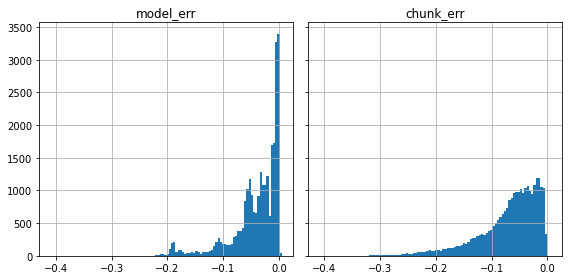

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

join_df[["model_err"]].hist(bins=100, ax=axes[0])
join_df[["chunk_err"]].hist(bins=100, ax=axes[1])

plt.tight_layout()

## DOI error over time compared to no model

<AxesSubplot:xlabel='chunk_no'>

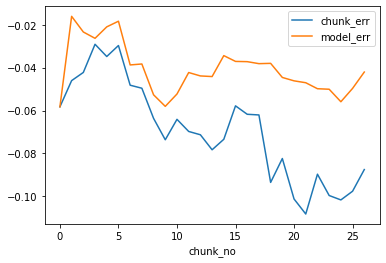

In [23]:
import numpy as np

join_df["chunk_no"] = np.arange(len(join_df)) // CHUNK_SIZE
join_df.groupby("chunk_no")[["chunk_err", "model_err"]].mean().plot()

## Number of most interesting items in visualization

<AxesSubplot:>

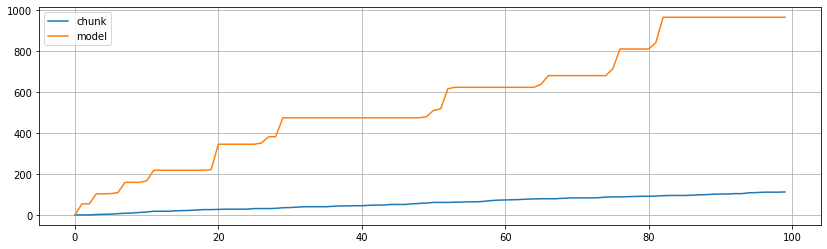

In [99]:
import numpy as np
import pandas as pd

# monolithic_df = pd.read_csv("./monolithic.csv", index_col="id")
# chunked_df = pd.read_csv("chunked.csv", index_col="id")
# model_df = pd.read_csv("model.csv", index_col="id")

K = 1000

sort_by_doi_mono = np.argsort(monolithic_df["doi"])
sorted_df = monolithic_df.iloc[sort_by_doi_mono][::-1]
top_k_ids = sorted_df[:K].index

model_df["chunk_no"] = np.arange(len(model_df)) // CHUNK_SIZE
chunked_df["chunk_no"] = np.arange(len(chunked_df)) // CHUNK_SIZE

top_k_in_chunk = []
top_k_in_model = []

for i in range(N_CHUNKS):
  ids_in_chunk = chunked_df[chunked_df["chunk_no"] <= i].index
  ids_in_model = model_df[model_df["chunk_no"] <= i].index

  top_k_in_chunk += [ids_in_chunk.isin(top_k_ids).sum()]
  top_k_in_model += [ids_in_model.isin(top_k_ids).sum()]

pd.DataFrame(np.array([top_k_in_chunk, top_k_in_model]).T, columns=["chunk", "model"]).plot(grid=True, figsize=(14, 4))

## Impact on the visualization compared to no model

### Focus+Context

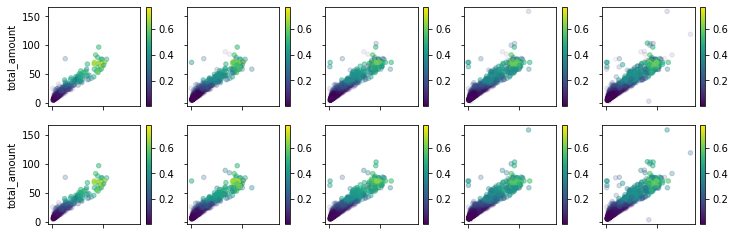

In [16]:
import matplotlib.pyplot as plt

N_STEPS = 5

fig, axes = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)

for i in range(N_STEPS):
  slice_df = join_df.iloc[0:(i+1)*CHUNK_SIZE]
  slice_df.plot.scatter(x="trip_distance", y="total_amount", c=slice_df["doi_model"], alpha=slice_df["doi_model"], ax=axes[0][i], cmap="viridis")
  slice_df.plot.scatter(x="trip_distance", y="total_amount", c=slice_df["doi_chunk"], alpha=slice_df["doi_chunk"], ax=axes[1][i], cmap="viridis")

### Top-k items

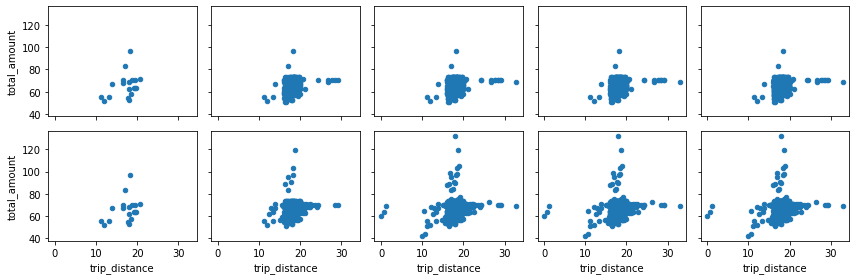

In [17]:
import matplotlib.pyplot as plt
import numpy as np

N_STEPS = 5
K = 250

fig, axes = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)

for i in range(N_STEPS):
  step = int((i/N_STEPS)*N_CHUNKS)
  # slice_df = join_df.iloc[step*CHUNK_SIZE:(step+1)*CHUNK_SIZE]
  slice_df = join_df.iloc[0:(step+1)*CHUNK_SIZE]

  topk_model_df = slice_df[slice_df["doi_model"] > 0.5]
  topk_model_df.plot.scatter(x="trip_distance", y="total_amount", ax=axes[0][i])

  topk_chunk_df = slice_df[slice_df["doi_chunk"] > 0.5]
  topk_chunk_df.plot.scatter(x="trip_distance", y="total_amount", ax=axes[1][i])

fig.tight_layout()
  

<hr>

## Additional Tests

In [ ]:
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import Benchmark


def benchmark_max_depth(tested_max_depths: range = range(1, 10)):
  '''Measures how varying `max_depth` parameter influences progressive DOI prediction scores, over 
  a series of chunks (without retraining) --- how stable/overfitted is the tree model.'''
  benchmark = Benchmark(max_depths=tested_max_depths)
  scores = benchmark.run()
  return scores


def benchmark_retraining_intervals(tested_intervals: range = range(25)):
  '''Measures how varying the update interval influences progressive DOI prediction scores.'''
  benchmark = Benchmark(intervals=tested_intervals)
  scores = benchmark.run()
  return scores


def benchmark_chunk_size(tested_sizes: range = range(1000, 110000, 10000)):
  '''Measures how varying the chunk size influences the progressive DOI prediction scores (without
   retraining, without context)'''
  benchmark = Benchmark(chunk_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_context_size(tested_sizes: range = range(0, 11000, 1000)):
  '''Measures how varying the context size influences the progressive DOI prediction scores (without
   retraining)'''
  benchmark = Benchmark(context_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_context_strategies(context_strats=["stratified", "minmax"]):
  benchmark = Benchmark(n_chunks=50, context_size=500, intervals=50, measure_doi_error=True, context_strats=context_strats)
  scores = benchmark.run()

  return scores


def benchmark_doi_error_without_context():
  '''Measures the changes in DOI error throughout the progression, when no optimizations are 
   applied.'''
  benchmark = Benchmark(n_chunks=100, chunk_size=1000, measure_doi_error=True)
  scores = benchmark.run()

  return scores

  
def benchmark_doi_error_with_context():
  '''Measures the changes in DOI error throughout the progression, when context optimizations are 
   applied.'''
  benchmark = Benchmark(n_chunks=100, chunk_size=1000, measure_doi_error=True, context_size=1000, intervals=5, context_strats="stratified")
  scores = benchmark.run()

  return scores

def benchmark_retraining_strategies():
  '''Measures the changes in DOI error throughout the progression, when context is applied by simply predicting the DOI'''

  benchmark = Benchmark(n_chunks=10, chunk_size=1000, context_size=1000, intervals=5, measure_doi_error=True, measure_timings=True, include_previous_chunks_in_training=[True, False])
  scores = benchmark.run()

  return scores, benchmark

def benchmark_with_without_model():
  '''Measures the impact of using vs. not using the regression tree model for computing the user interest.'''
  benchmark = Benchmark(measure_doi_error=True)

  scores = benchmark.run()
  return scores, benchmark

# TODO: show reduction in overall error when updating "outdated" values with each new model

# results: max_depth = 3 has best peformance, then no improvement/worse for bigger values
# max_depth_results = benchmark_max_depth()

# results: trivial best results for 0 and 1, score std for 3-8 above 0.9 
# intervals_results = benchmark_retraining_intervals()

# results: the larger the context the worse the scores.
# context_size_results = benchmark_context_size()

# results: the larger the chunk size, the better the scores
# chunk_size_results = benchmark_chunk_size()

# results: minmax worse than stratified sampling
# context_strategies_results = benchmark_context_strategies()

# results: overall error increases with every chunk -> DOI values "age"
# doi_error_without_context_results = benchmark_doi_error_without_context()

# results: error increases over time but not as badly as without the context and it gets better
# doi_error_with_context_results = benchmark_doi_error_with_context()

# results: including the prior model in the update 
# doi_error_with_prediction_context = benchmark_retraining_strategies()

with_without_model = benchmark_with_without_model()

In [8]:
import matplotlib.pyplot as plt
s = with_without_model[1].storages[0]

nrow = 1
ncol = 3
plot_size = 4
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * plot_size, plot_size), sharex=True, sharey=True)

for i in range(ncol):
  # chunk_df = s.get_items_for_chunks(chunks=list(range(i + 1)), as_df=True)
  chunk_df = s.get_items_for_chunks(chunks=[i], as_df=True)
  doi = s.get_doi_for_ids(chunk_df["tripID"].tolist())
  chunk_df["doi"] = doi.astype(float)
  
  chunk_df.plot.scatter(
    x="trip_distance", 
    y="total_amount", 
    alpha=chunk_df["doi"], 
    c=chunk_df["doi"], 
    ax=axes[i], 
    cmap="viridis"
  )
  axes[i].set_xticks([])
  axes[i].set_yticks([])

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0], cax=cbar_ax)

plt.tight_layout()

NameError: name 'with_without_model' is not defined

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

doi_error_with_prediction_context[~doi_error_with_prediction_context["include_previous_chunks_in_training"]].plot(x="chunk", y="error_mean", ax=axes[0])
doi_error_with_prediction_context[doi_error_with_prediction_context["include_previous_chunks_in_training"]].plot(x="chunk", y="error_mean", ax=axes[1])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

doi_error_with_prediction_context.boxplot(column="score", by="include_previous_chunks_in_training", ax=axes[0])

doi_error_with_prediction_context[~doi_error_with_prediction_context["include_previous_chunks_in_training"]].plot(y="score", x="chunk", ax=axes[1])

doi_error_with_prediction_context[doi_error_with_prediction_context["include_previous_chunks_in_training"]].plot(y="score", x="chunk", ax=axes[2])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

doi_error_without_context_results["error_std"].plot(ax=axes[0])
doi_error_with_context_results["error_std"].plot(ax=axes[1])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

context_strategies_results.boxplot(column="error_std", by="context_strat", ax=axes[0])
context_strategies_results.plot(y="error_std", x="chunk",  ax=axes[1])


In [ ]:
max_depth_results.boxplot(column="score", by="max_depth")

In [ ]:
intervals_results.boxplot(column="score", by="interval")

In [ ]:
context_size_results.boxplot(column="score", by="context_size")

In [ ]:
chunk_size_results.boxplot(column="score", by="chunk_size")